In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!nvidia-smi

Fri Jul 23 06:09:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-cb437013-6bd1-42f1-b6e9-b3d059a55a5a)


In [8]:
# To unzip 
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/Colab Notebooks/data_64.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


In [9]:
# import the libraries as shown below
 
from tensorflow import keras
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.preprocessing import image
import os, time, shutil
import numpy as np
from glob import glob
import matplotlib.pyplot as plt


In [10]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]
 
train_path = '/content/data_64/train'
valid_path = '/content/data_64/test'


In [11]:
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights
 
ResNet50_model = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in ResNet50_model.layers:
    layer.trainable = False


94773248/94765736 [==============================] - 0s 0us/step


In [12]:
# useful for getting number of output classes
folders = glob('/content/data_64/train/*')
folders

['/content/data_64/train/5',
 '/content/data_64/train/3',
 '/content/data_64/train/0',
 '/content/data_64/train/1',
 '/content/data_64/train/2',
 '/content/data_64/train/4']

In [13]:
# our layers - you can add more if you want
x = Flatten()(ResNet50_model.output)

In [14]:
prediction = Dense(len(folders), activation='softmax')(x)
 
# create a model object
model = Model(inputs=ResNet50_model.input, outputs=prediction)

In [15]:
# view the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [16]:
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
 
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
# Checkpoint's 
# https://keras.io/api/callbacks/model_checkpoint/
 
filepath="model_ResNet50-{epoch:02d}-{val_accuracy:.3f}-{val_loss:.3f}.h5"
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')
callbacks_list = [checkpoint]


In [18]:
# Use the Image Data Generator to import the images from the dataset
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
 
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.1,
                                   zoom_range = 0.1,
                                   horizontal_flip = True)
 
test_datagen = ImageDataGenerator(rescale = 1./255)

In [19]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/data_64/train',
                                                 target_size = (224, 224),
                                                 batch_size = 128,
                                                 class_mode = 'categorical')
 
test_set = test_datagen.flow_from_directory('/content/data_64/test',
                                            target_size = (224, 224),
                                            batch_size = 128,
                                            class_mode = 'categorical')


Found 5787 images belonging to 6 classes.
Found 3859 images belonging to 6 classes.


In [20]:
# fit the model
# Run the cell. It will take some time to execute
 
start = time.time()
 
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set),
  callbacks=callbacks_list
)
print('\n\n')
print(f'Time: {time.time() - start}')
 
model.save('ResNet50_model.h5')


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
46/46 [==============================] - 136s 2s/step - loss: 59.0886 - accuracy: 0.2426 - val_loss: 20.2533 - val_accuracy: 0.3009

Epoch 00001: val_loss improved from inf to 20.25328, saving model to model_ResNet50-01-0.301-20.253.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
46/46 [==============================] - 103s 2s/step - loss: 25.0424 - accuracy: 0.3138 - val_loss: 16.9358 - val_accuracy: 0.2788

Epoch 00002: val_loss improved from 20.25328 to 16.93576, saving model to model_ResNet50-02-0.279-16.936.h5
Epoch 3/50
46/46 [==============================] - 102s 2s/step - loss: 12.2548 - accuracy: 0.3942 - val_loss: 8.8000 - val_accuracy: 0.3581

Epoch 00003: val_loss improved from 16.93576 to 8.79999, saving model to model_ResNet50-03-0.358-8.800.h5
Epoch 4/50
46/46 [==============================] - 102s 2s/step - loss: 9.4517 - accuracy: 0.4113 - val_loss: 11.2760 - val_accuracy: 0.3716

Epoch 00004: val_loss did not improve from 8.79999
Epoch 5/50
46/46 [==============================] - 102s 2s/step - loss: 11.0639 - accuracy: 0.4208 - val_loss: 7.0918 - val_accuracy: 0.4978

Epoch 00005: val_loss improved from 8.79999 to 7.09184, saving model to model_ResNet50-05-0.498-7.092.h5
Epoch 6/50
46/46 [==============================] - 103s 

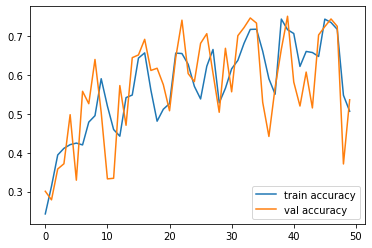

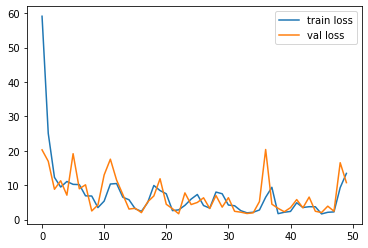

In [21]:
# accuracies
plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.savefig('accuracy_and_val_accuracy.png', dpi=200)
plt.show()
 
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('loss_and_val_loss.png', dpi=200)
plt.show()


In [23]:
from glob import glob
import os
 
model = load_model('/content/model_ResNet50-23-0.741-1.683.h5')
model.summary()
 
data = []
labels = []
classes = glob('/content/data_64/val1/*') # data/train/* # data/test/*
print('Number of classes : ', classes)
cur_path = os.getcwd()
print('cur_path : ', cur_path)


from PIL import Image
 
# Retrieving the images and their labels 
for i in range(len(classes)):
    path = os.path.join(cur_path,'data_64/val1',str(i))
    print('path : ',path)
    images = os.listdir(path)
    # print('images : ',images)
    
    for a in images:
        try:
            image = Image.open(path + '/'+ a)            
            image = image.resize((224,224))
            image = np.array(image)
            data.append(image)
            labels.append(i)
        except:
            print("Error loading image")
print('loaded ...')
 



y_true = []
y_pred = []
 
for i in range(len(data)):
    x = data[i]
    x = np.expand_dims(x, axis=0)
    img_data = preprocess_input(x)
    classes = model.predict(img_data)
    li = list(classes[0])
    y_pred.append(li.index(max(li)))
    y_true.append(labels[i])
    
    # print('y_true : ', y_true[i], ' y_pred : ', y_pred[i])
 
print('done...')


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

[[  0   0   0 268  19  51]
 [  0   0   0 334  10  55]
 [  0   0   0 309  20 112]
 [  0   1   0 579  62 204]
 [  0   0   0 363  24 180]
 [  0   0   0 148  73  82]] 

Accuracy: 0.236697 

Error rate: 0.763303 

classification_report 

               precision    recall  f1-score   support

           0       0.00      0.00      0.00       338
           1       0.00      0.00      0.00       399
           2       0.00      0.00      0.00       441
           3       0.29      0.68      0.41       846
           4       0.12      0.04      0.06       567
           5       0.12      0.27      0.17       303

    accuracy                           0.24      2894
   macro avg       0.09      0.17      0.11      2894
weighted avg       0.12      0.24      0.15      2894
 

Cohens kappa: -0.005670


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


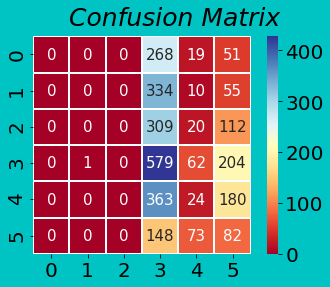

In [24]:
# confusion matrix
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_true,y_pred)
print(matrix, '\n')
 
# accuracy: (tp + tn) / (p + n)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true, y_pred)
print('Accuracy: %f' % accuracy, '\n')
print('Error rate: %f' % (1-accuracy), '\n')
 
from sklearn.metrics import classification_report
print("classification_report \n\n", classification_report(y_true,y_pred), '\n')
 
# kappa
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(y_true,y_pred)
print('Cohens kappa: %f' % kappa)
 
# Commented out IPython magic to ensure Python compatibility.
import matplotlib.pyplot as plt
# %matplotlib inline
import seaborn as sns 
 
plt.rcParams['font.size'] = 20
bg_color = (0,0.77,0.77)
plt.rcParams['figure.facecolor'] = bg_color
plt.rcParams['axes.facecolor'] = bg_color
 
fig, ax = plt.subplots(1)
 
plt.text(1,-.3, "Confusion Matrix", fontsize = 25, color='Black', fontstyle='italic')
 
ax = sns.heatmap(matrix, annot=True, annot_kws={'size':15}, fmt="d", 
                 robust=True, linewidths=.9, cmap="RdYlBu", square=True)
# vmin=0, vmax=350,
plt.savefig("model_ResNet50.jpeg", dpi=200, facecolor=bg_color, transparent=True)
plt.show()
